<a href="https://colab.research.google.com/github/13025305900/Email-classification/blob/main/Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install "transformer" library
!pip uninstall tensorflow transformers -y
!pip install tensorflow==2.12.0 transformers==4.28.0

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Found existing installation: transformers 4.28.0
Uninstalling transformers-4.28.0:
  Successfully uninstalled transformers-4.28.0
  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached transformers-4.28.0-py3-none-any.whl.metadata (109 kB)
Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)
Using cached transformers-4.28.0-py3-none-any.whl (7.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 which is incompatible.
sentence-transfo

In [2]:
# Import Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

#Bert
from tensorflow.keras.layers import Input, Dense
from transformers import BertTokenizer, TFBertForSequenceClassification

#CNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

#ML
#逻辑回归
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, ConfusionMatrixDisplay

#ML
#RF
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#ML
#SVM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

In [3]:
# Load Pre-trained BERT Model and Tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Show the model
bert_model.summary()

In [ ]:
# Load spam/ham email dataset
data = pd.read_csv("./email.csv")
data.head()

In [6]:
# Text message
email_texts = data.Message
email_texts = list(email_texts)

In [7]:
print(email_texts)

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'U dun say so early hor... U c already then say...', "Nah I don't think he goes to usf, he lives around here though", "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv", 'Even my brother is not like to speak with me. They treat me like aids patent.', "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune", 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.', 'Had your mobile 

In [8]:
# Transform the lebel by spam = 1 and ham = 0
labels = data.Category.apply(lambda x: 1 if x=="spam" else 0)
# Prepare Labels
labels = np.array(labels)

In [9]:
print(labels)

[0 0 1 ... 0 0 0]


In [10]:
# Tokenize and Pad Data
max_length = 128
encoded_inputs = tokenizer(email_texts, padding=True, truncation=True, max_length=max_length, return_tensors='tf')
print(encoded_inputs.input_ids.shape)
print()
print(encoded_inputs.token_type_ids.shape)
print()
print(encoded_inputs.attention_mask.shape)
print()

(5572, 128)

(5572, 128)

(5572, 128)



In [11]:
# Split Data into Training and Validation Sets
train_ratio = 0.8
num_train_samples = int(len(email_texts) * train_ratio)

train_inputs = {key: val[:num_train_samples] for key, val in encoded_inputs.items()}
test_inputs = {key: val[num_train_samples:] for key, val in encoded_inputs.items()}
train_labels = labels[:num_train_samples]
test_labels = labels[num_train_samples:]

In [12]:
# Compile the Model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [13]:
# Initialize the GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  pass

In [14]:
# Train the Model
epochs = 3
batch_size = 32

with tf.device(device_name):
  history = bert_model.fit(x=train_inputs, y=train_labels, validation_data=(test_inputs, test_labels),
                           epochs=epochs,batch_size=batch_size)

Epoch 1/3
140/140 [==============================] - 4014s 28s/step - loss: 0.1035 - accuracy: 0.9726 - val_loss: 0.0734 - val_accuracy: 0.9767
Epoch 2/3
140/140 [==============================] - 4072s 29s/step - loss: 0.0786 - accuracy: 0.9778 - val_loss: 0.0686 - val_accuracy: 0.9794
Epoch 3/3
140/140 [==============================] - 4032s 29s/step - loss: 0.0697 - accuracy: 0.9785 - val_loss: 0.0357 - val_accuracy: 0.9928


In [15]:
# show the loss and accuracy through each iteration
print(history.history['loss'])
print(history.history['accuracy'])
print(history.history['val_loss'])
print(history.history['val_accuracy'])

[0.10348358005285263, 0.07855454087257385, 0.06967421621084213]
[0.9726273417472839, 0.9777877330780029, 0.9784608483314514]
[0.07335154712200165, 0.0686456486582756, 0.03567180410027504]
[0.9766815900802612, 0.9793722033500671, 0.9928250908851624]


In [18]:
# Plot function
def plotHistory(val,nm):
  plt.figure(figsize=(5,2))
  plt.plot(val)
  plt.xlabel("Count of Iteration")
  plt.ylabel(str(nm))
  plt.title(nm)
  plt.show()

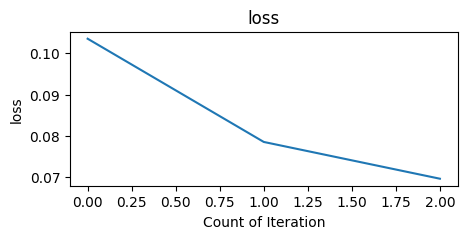

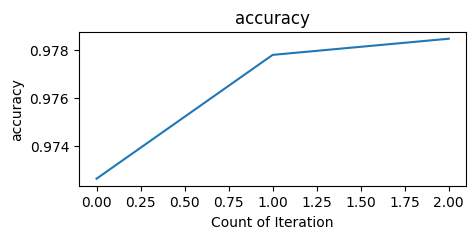

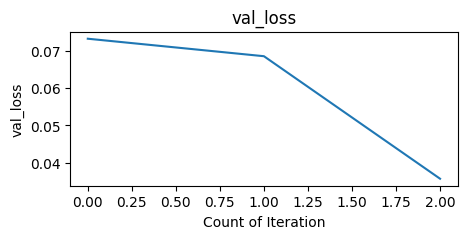

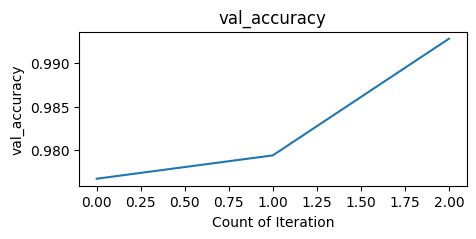

 4/35 [==>...........................] - ETA: 3:53

In [ ]:
# Plot loss
plotHistory(history.history['loss'],'loss')

# Plot accuracy
plotHistory(history.history['accuracy'],'accuracy')

# Plot validation loss
plotHistory(history.history['val_loss'],'val_loss')

# Plot validation accuracy
plotHistory(history.history['val_accuracy'],'val_accuracy')

In [20]:
# Predict the bert model
pred_lebel = bert_model.predict(test_inputs)

35/35 [==============================] - 292s 8s/step


In [21]:
# Show the actual prediction
print(pred_label)

TFSequenceClassifierOutput(loss=None, logits=array([[ 3.355116 , -3.4427695],
       [ 3.3767476, -3.4708123],
       [ 3.3614306, -3.452406 ],
       ...,
       [ 3.354229 , -3.4474132],
       [ 3.3566267, -3.4486442],
       [ 3.3606973, -3.4497974]], dtype=float32), hidden_states=None, attentions=None)


In [22]:
# Important part of prediction
pred_label.logits

array([[ 3.355116 , -3.4427695],
       [ 3.3767476, -3.4708123],
       [ 3.3614306, -3.452406 ],
       ...,
       [ 3.354229 , -3.4474132],
       [ 3.3566267, -3.4486442],
       [ 3.3606973, -3.4497974]], dtype=float32)

In [23]:
# Transform the prediction label to standard label
predicted_labels = np.argmax(pred_label.logits, axis=-1)
# Show shape of predicted label
print(predicted_labels.shape)

(1115,)


In [24]:
# show label
print(predicted_labels)

[0 0 0 ... 0 0 0]


In [25]:
# Import and show the result
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
confusion_matrix(test_labels, predicted_labels)

array([[967,   3],
       [  5, 140]])

<Figure size 100x100 with 0 Axes>

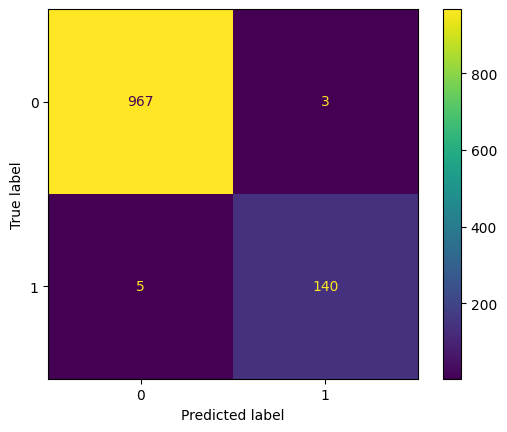

In [26]:
# Plot the result
cm = confusion_matrix(test_labels, predicted_labels, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
plt.figure(figsize=(1,1))
disp.plot()
plt.show()

Accuracy: 0.9928251121076234
Precision: 0.9790209790209791
Recall: 0.9655172413793104
F1 Score: 0.9722222222222222


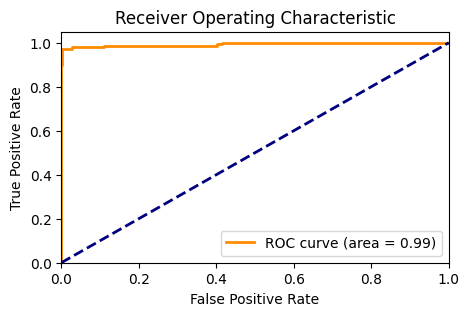

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       970
        spam       0.98      0.97      0.97       145

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [29]:
# Accuracy score
accuracy=accuracy_score(test_labels, predicted_labels)
print("Accuracy:", accuracy)

# Import Libraries
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, classification_report

# 计算精确率（Precision）
precision = precision_score(test_labels, predicted_labels)
print("Precision:", precision)

# 计算召回率（Recall）
recall = recall_score(test_labels, predicted_labels)
print("Recall:", recall)

# 计算 F1 分数（F1 Score）
f1 = f1_score(test_labels, predicted_labels)
print("F1 Score:", f1)

# 计算 ROC 曲线和 AUC
# 获取模型的预测概率
y_pred_prob = tf.nn.softmax(pred_lebel.logits, axis=-1).numpy()
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob[:, 1])  # 假设正类为1
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 打印分类报告
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=["ham", "spam"]))

In [30]:
#CNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 128, 128)          1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 124, 128)          82048     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_40 (Dropout)        (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                      

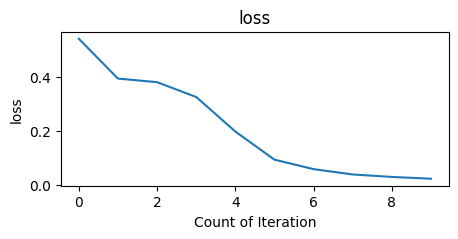

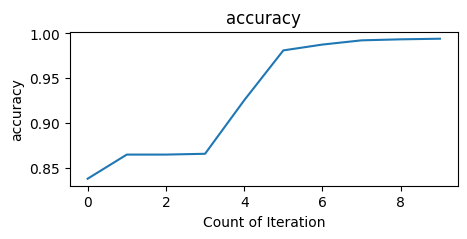

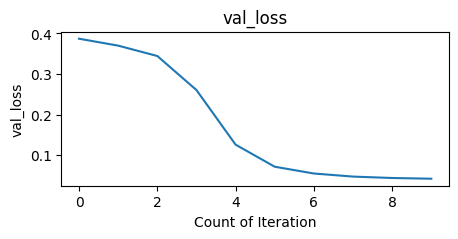

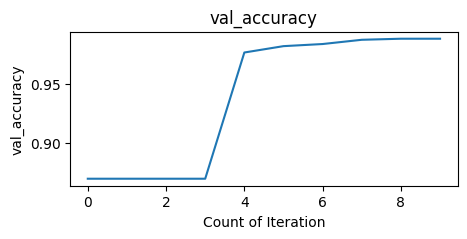

35/35 [==============================] - 0s 8ms/step
(1115,)
[0 0 0 ... 0 0 0]


<Figure size 400x400 with 0 Axes>

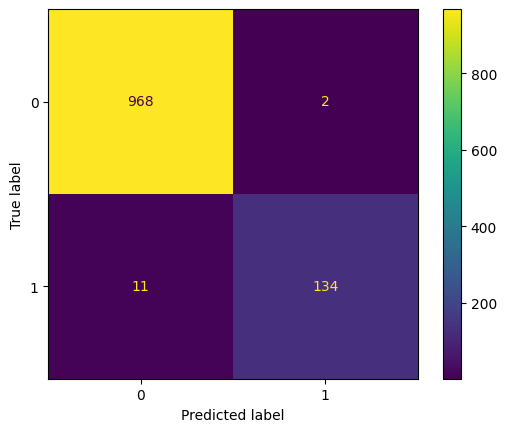

Accuracy: 0.9883408071748879
Precision: 0.9852941176470589
Recall: 0.9241379310344827
F1 Score: 0.9537366548042705
AUC-ROC: 0.9935869178812655
Classification Report:
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       970
        spam       0.99      0.92      0.95       145

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



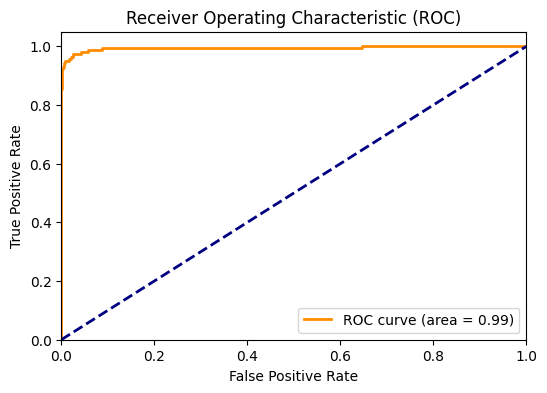

AUC: 0.9935869178812655


In [34]:
#CNN
# Load data
data = pd.read_csv('email.csv')
email_texts = data['Message'].values
labels = data['Category'].apply(lambda x: 1 if x == "spam" else 0).values

# Tokenize and Pad Data
max_words = 10000  # 最大词汇量
max_length = 128  # 最大序列长度
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(email_texts)
sequences = tokenizer.texts_to_sequences(email_texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Split Data into Training and Validation Sets
train_ratio = 0.8
num_train_samples = int(len(email_texts) * train_ratio)

train_inputs = padded_sequences[:num_train_samples]
test_inputs = padded_sequences[num_train_samples:]
train_labels = labels[:num_train_samples]
test_labels = labels[num_train_samples:]

# Build CNN Model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # 二分类问题使用sigmoid激活函数

# Compile the Model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy(name='accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Show the model summary
model.summary()

# Train the Model
epochs = 10
batch_size = 32

history = model.fit(x=train_inputs, y=train_labels, validation_data=(test_inputs, test_labels),
                    epochs=epochs, batch_size=batch_size)

# Show the loss and accuracy through each iteration
print(history.history['loss'])
print(history.history['accuracy'])
print(history.history['val_loss'])
print(history.history['val_accuracy'])

# Plot function
def plotHistory(val, nm):
    plt.figure(figsize=(5, 2))
    plt.plot(val)
    plt.xlabel("Count of Iteration")
    plt.ylabel(str(nm))
    plt.title(nm)
    plt.show()

# Plot loss
plotHistory(history.history['loss'], 'loss')

# Plot accuracy
plotHistory(history.history['accuracy'], 'accuracy')

# Plot validation loss
plotHistory(history.history['val_loss'], 'val_loss')

# Plot validation accuracy
plotHistory(history.history['val_accuracy'], 'val_accuracy')

# Predict the model
pred_labels = model.predict(test_inputs)
predicted_labels = (pred_labels > 0.5).astype(int).flatten()

# Show shape of predicted labels
print(predicted_labels.shape)

# Show labels
print(predicted_labels)

# Import and show the result
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
plt.figure(figsize=(4, 4))
disp.plot()
plt.show()

# Accuracy score
print("Accuracy:", accuracy_score(test_labels, predicted_labels))

# 计算精确率
precision = precision_score(test_labels, predicted_labels)
print("Precision:", precision)

# 计算召回率
recall = recall_score(test_labels, predicted_labels)
print("Recall:", recall)

# 计算F1分数
f1 = f1_score(test_labels, predicted_labels)
print("F1 Score:", f1)

# 计算AUC-ROC曲线
auc_roc = roc_auc_score(test_labels, pred_labels)
print("AUC-ROC:", auc_roc)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=['ham', 'spam']))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC value
print("AUC:", roc_auc)

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'U dun say so early hor... U c already then say...', "Nah I don't think he goes to usf, he lives around here though", "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv", 'Even my brother is not like to speak with me. They

<Figure size 500x500 with 0 Axes>

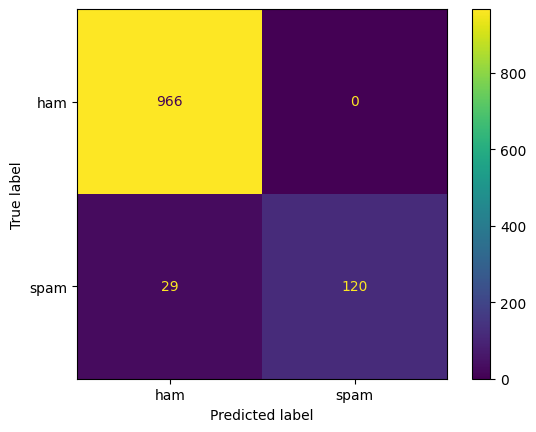

Accuracy: 0.97
Precision: 1.00
Recall: 0.81
F1 Score: 0.89


In [35]:
#ML
#逻辑回归
# Load Data
data = pd.read_csv('email.csv')

# Show the data
print(data.head())

# Text message
email_texts = data['Message']
email_texts = list(email_texts)
print(email_texts)

# Transform the label by spam = 1 and ham = 0
labels = data['Category'].apply(lambda x: 1 if x == "spam" else 0)
labels = np.array(labels)
print(labels)

# Split Data into Training and Validation Sets
train_texts, test_texts, train_labels, test_labels = train_test_split(email_texts, labels, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features to 5000 for simplicity
train_vectors = vectorizer.fit_transform(train_texts)
test_vectors = vectorizer.transform(test_texts)


# Initialize and train a machine learning model (Logistic Regression)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(train_vectors, train_labels)
lr_probabilities = lr_model.predict_proba(test_vectors)[:, 1]

# Predict on the test set
lr_predicted_labels = lr_model.predict(test_vectors)

# Show shape of predicted labels
print(lr_predicted_labels.shape)

# Show labels
print(lr_predicted_labels)

# Plot the result
cm = confusion_matrix(test_labels, lr_predicted_labels, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
plt.figure(figsize=(5, 5))
disp.plot()
plt.show()

# Accuracy score
accuracy = accuracy_score(test_labels, lr_predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 计算精确率
precision = precision_score(test_labels, lr_predicted_labels)
print(f'Precision: {precision:.2f}')

# 计算召回率
recall = recall_score(test_labels, lr_predicted_labels)
print(f'Recall: {recall:.2f}')

# 计算 F1 分数
f1 = f1_score(test_labels, lr_predicted_labels)
print(f'F1 Score: {f1:.2f}')

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'U dun say so early hor... U c already then say...', "Nah I don't think he goes to usf, he lives around here though", "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv", 'Even my brother is not like to speak with me. They

<Figure size 500x500 with 0 Axes>

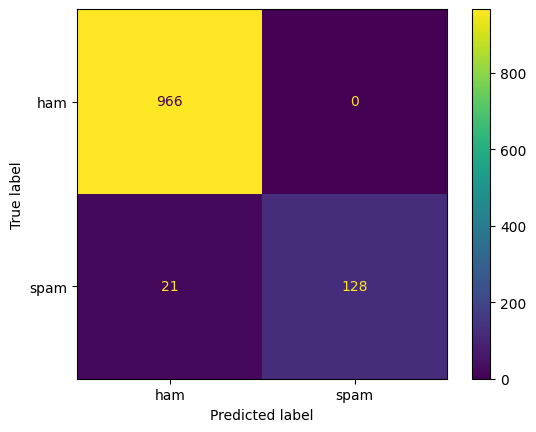

Random Forest Accuracy: 0.98
Precision: 1.00
Recall: 0.86
F1 Score: 0.92


In [36]:
#ML
#Try another model (Random Forest)

# Load Data
data = pd.read_csv('email.csv')

# Show the data
print(data.head())

# Text message
email_texts = data['Message']
email_texts = list(email_texts)
print(email_texts)

# Transform the label by spam = 1 and ham = 0
labels = data['Category'].apply(lambda x: 1 if x == "spam" else 0)
labels = np.array(labels)
print(labels)

# Split Data into Training and Validation Sets
train_texts, test_texts, train_labels, test_labels = train_test_split(email_texts, labels, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features to 5000 for simplicity
train_vectors = vectorizer.fit_transform(train_texts)
test_vectors = vectorizer.transform(test_texts)

#Random forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_vectors, train_labels)
rf_predicted_labels = rf_model.predict(test_vectors)
rf_probabilities = rf_model.predict_proba(test_vectors)[:, 1]

# Plot the result for Random Forest
rf_cm = confusion_matrix(test_labels, rf_predicted_labels, labels=[0, 1])
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['ham', 'spam'])
plt.figure(figsize=(5, 5))
rf_disp.plot()
plt.show()

# Accuracy score for Random Forest
rf_accuracy = accuracy_score(test_labels, rf_predicted_labels)
print(f'Random Forest Accuracy: {rf_accuracy:.2f}')

# 计算精确率
precision = precision_score(test_labels, rf_predicted_labels)
print(f'Precision: {precision:.2f}')

# 计算召回率
recall = recall_score(test_labels, rf_predicted_labels)
print(f'Recall: {recall:.2f}')

# 计算 F1 分数
f1 = f1_score(test_labels, rf_predicted_labels)
print(f'F1 Score: {f1:.2f}')

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'U dun say so early hor... U c already then say...', "Nah I don't think he goes to usf, he lives around here though", "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv", 'Even my brother is not like to speak with me. They

<Figure size 500x500 with 0 Axes>

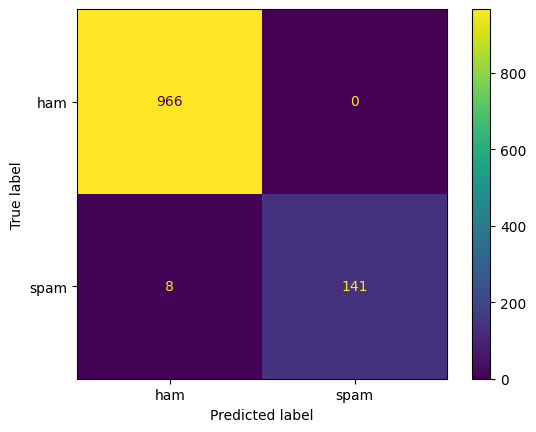

SVM Accuracy: 0.99
SVM Precision: 1.00
SVM Recall: 0.95
SVM F1 Score: 0.97


In [37]:
# Load Data
data = pd.read_csv('email.csv')

# Show the data
print(data.head())

# Text message
email_texts = data['Message']
email_texts = list(email_texts)
print(email_texts)

# Transform the label by spam = 1 and ham = 0
labels = data['Category'].apply(lambda x: 1 if x == "spam" else 0)
labels = np.array(labels)
print(labels)

# Split Data into Training and Validation Sets
train_texts, test_texts, train_labels, test_labels = train_test_split(email_texts, labels, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features to 5000 for simplicity
train_vectors = vectorizer.fit_transform(train_texts)
test_vectors = vectorizer.transform(test_texts)

# Initialize and train a machine learning model (Support Vector Machine)
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_vectors, train_labels)

# Predict on the test set
svm_predicted_labels = svm_model.predict(test_vectors)
svm_probabilities = svm_model.predict_proba(test_vectors)[:, 1]

# Show shape of predicted labels
print(svm_predicted_labels.shape)

# Show labels
print(svm_predicted_labels)

# Plot the result
svm_cm = confusion_matrix(test_labels, svm_predicted_labels, labels=[0, 1])
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=['ham', 'spam'])
plt.figure(figsize=(5, 5))
svm_disp.plot()
plt.show()

# Accuracy score
svm_accuracy = accuracy_score(test_labels, svm_predicted_labels)
print(f'SVM Accuracy: {svm_accuracy:.2f}')

# Precision score
svm_precision = precision_score(test_labels, svm_predicted_labels)
print(f'SVM Precision: {svm_precision:.2f}')

# Recall score
svm_recall = recall_score(test_labels, svm_predicted_labels)
print(f'SVM Recall: {svm_recall:.2f}')

# F1 score
svm_f1 = f1_score(test_labels, svm_predicted_labels)
print(f'SVM F1 Score: {svm_f1:.2f}')

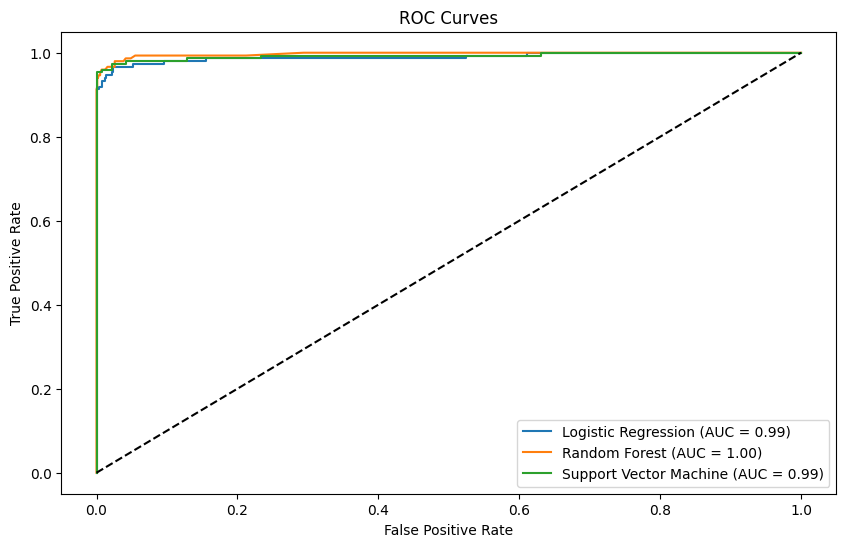

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.86      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       966
           1       1.00      0.95      0.97       149

    accuracy                           0.99      1115
  

In [38]:
# Plot ROC Curves of ML
plt.figure(figsize=(10, 6))
fpr_lr, tpr_lr, _ = roc_curve(test_labels, lr_probabilities)
fpr_rf, tpr_rf, _ = roc_curve(test_labels, rf_probabilities)
fpr_svm, tpr_svm, _ = roc_curve(test_labels, svm_probabilities)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc(fpr_lr, tpr_lr):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'Support Vector Machine (AUC = {auc(fpr_svm, tpr_svm):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Classification Reports
print("Logistic Regression Classification Report:")
print(classification_report(test_labels, lr_predicted_labels))

print("Random Forest Classification Report:")
print(classification_report(test_labels, rf_predicted_labels))

print("Support Vector Machine Classification Report:")
print(classification_report(test_labels, svm_predicted_labels))

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
Total number of rows in the data: 5572
Total number of messages: 5572
Total number of labels: 5572
Number of training samples: 4457
Number of test samples: 1115
Shape of training vectors: (4457, 5000)
Shape of test vectors: (1115, 5000)
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.86      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



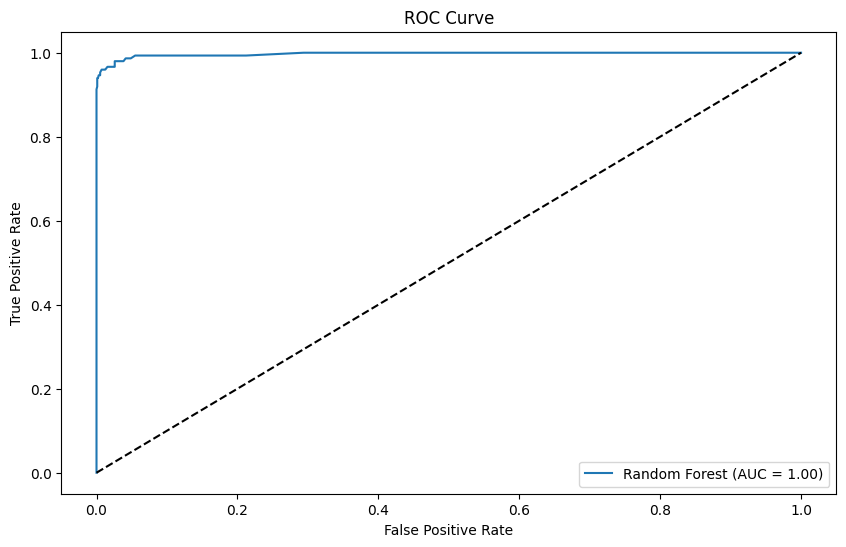

In [39]:
#This block is just for checking the number of dataset
#Load Data
data = pd.read_csv('email.csv')

# Show the data
print(data.head())

# Check the number of rows in the data
print(f'Total number of rows in the data: {len(data)}')

# Text message
email_texts = data['Message']
email_texts = list(email_texts)
print(f'Total number of messages: {len(email_texts)}')

# Transform the label by spam = 1 and ham = 0
labels = data['Category'].apply(lambda x: 1 if x == "spam" else 0)
labels = np.array(labels)
print(f'Total number of labels: {len(labels)}')

# Split Data into Training and Validation Sets
train_texts, test_texts, train_labels, test_labels = train_test_split(email_texts, labels, test_size=0.2, random_state=42)

# Check the number of samples in the training and test sets
print(f'Number of training samples: {len(train_texts)}')
print(f'Number of test samples: {len(test_texts)}')

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features to 5000 for simplicity
train_vectors = vectorizer.fit_transform(train_texts)
test_vectors = vectorizer.transform(test_texts)

# Check the shape of the training and test vectors
print(f'Shape of training vectors: {train_vectors.shape}')
print(f'Shape of test vectors: {test_vectors.shape}')

# Initialize and train a machine learning model (Random Forest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_vectors, train_labels)
rf_predicted_labels = rf_model.predict(test_vectors)
rf_probabilities = rf_model.predict_proba(test_vectors)[:, 1]

# Classification Report
print("Random Forest Classification Report:")
print(classification_report(test_labels, rf_predicted_labels))

# Plot ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(test_labels, rf_probabilities)
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()